# Navigation

---

In this project we will train an agent to collect bananas.

## 1. Start the Environment

Starting the environment.

In [1]:
!pip -q install tensorflow==1.7.1
!pip -q install ./python

ipython 6.5.0 has requirement prompt-toolkit<2.0.0,>=1.0.15, but you'll have prompt-toolkit 2.0.10 which is incompatible.


Import and run the environment.

In [2]:
from unityagents import UnityEnvironment
import numpy as np

env = UnityEnvironment(file_name="/data/Banana_Linux_NoVis/Banana.x86_64")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# Get the first brain and set it as the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

## 2. Examine the State and Action Spaces

Print information about the environment to get a better idea of how it is.

In [4]:
# Reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# Get the number of agents
print('Number of agents:', len(env_info.agents))

# Get the number of actions
action_size = brain.vector_action_space_size
print('\nNumber of actions:', action_size)

# Examine the state space 
state = env_info.vector_observations[0]
print('\nStates look like:\n', state)
state_size = len(state)
print('\nStates have length:', state_size)

Number of agents: 1

Number of actions: 4

States look like:
 [1.         0.         0.         0.         0.84408134 0.
 0.         1.         0.         0.0748472  0.         1.
 0.         0.         0.25755    1.         0.         0.
 0.         0.74177343 0.         1.         0.         0.
 0.25854847 0.         0.         1.         0.         0.09355672
 0.         1.         0.         0.         0.31969345 0.
 0.        ]

States have length: 37


## 3. Take Random Actions in the Environment

Practice using the Python API to control the agent.

In [5]:
def play(random=True):
    
    # Reset the environment
    env_info = env.reset(train_mode=True)[brain_name]
    # Get the current state
    state = env_info.vector_observations[0]
    # Initialize the score
    score, epsilon = 0, 0   
    
    while True:
        # Select a random action if random=True, otherwise get the action by calling the act() function of the agent
        action = np.random.randint(action_size) if random else agent.act(state, epsilon).astype(int)
        # Send the action to the environment
        env_info = env.step(action)[brain_name]     
        # Get the next state
        next_state = env_info.vector_observations[0]
        # Get the reward
        reward = env_info.rewards[0]
        # Check if episode has finished
        done = env_info.local_done[0]               
        # Update the score and the state
        score, state = score + reward, state+reward                                
    
        # Stop playing if the episode is finished
        if done:                                      
            break
    
    # Print the score
    print("Score: {}".format(score))

Play the game a few times. Play it by having the agent select its actions randomly.

In [6]:
num_tries = 3
for trial in range(num_tries):
    print('Trial {} '.format(trial))
    play()
    print()

Trial 0 
Score: 0.0

Trial 1 
Score: 2.0

Trial 2 
Score: -5.0



## 4. Use a neural network to teach the agent to play the game

Now we will use a neural network to teach the agent how to play the game.

The neural network is defined in `model.py`. It has 3 fully connected layers.
The agent itself and all its behaviors are defined in `agent.py`.

In [7]:
from model import QNetwork
from agent import Agent

In [8]:
# Use GPU if available
import torch

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [9]:
seed = 42

# Initialize the agent
agent = Agent(state_size  = brain.vector_observation_space_size, 
              action_size = brain.vector_action_space_size, 
              seed = seed)

Define the training loop.

In [10]:
import numpy as np
import random
from collections import namedtuple, deque

# Define training parameters
# Maximum number of training episodes
n_episodes = 2000
# Maximum number of timesteps per episode
max_t = 1000
# Starting value of epsilon, for epsilon-greedy action selection / minimum value of epsilon
eps_start, eps_end = 1.0, 0.01
# Multiplicative factor (per episode) for decreasing epsilon
eps_decay = 0.9
solved_eps = 0

def train(n_episodes=n_episodes, max_t=max_t, eps_start=eps_start, eps_end=eps_end, eps_decay=eps_decay):
    
    # Define variable that will contain the scores
    scores = []      
    # Get the last 100 scores
    scores_window = deque(maxlen=100) 
    # Initialize epsilon
    eps = eps_start          
    
    for i_episode in range(1, n_episodes+1):
        # reset the environment
        env_info = env.reset(train_mode=True)[brain_name]
        
        # examine the state space 
        state = env_info.vector_observations[0]  
        score = 0
        for t in range(max_t):
            
            # Select the epsilon-greedy action for the state
            action = agent.act(state, eps).astype(int)       
            
            # Forward the action to the environment
            env_info = env.step(action)[brain_name] 
            # Get the next state
            next_state = env_info.vector_observations[0]   
            # Get the reward
            reward = env_info.rewards[0]                   
            # Check if the episode has finished
            done = env_info.local_done[0]                  
            
            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward
            
            if done:
                break 
                
        # Save the most recent score
        scores_window.append(score)     
        scores.append(score)              
        # Decrease epsilon
        eps = max(eps_end, eps_decay*eps) 
        
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
            
        if np.mean(scores_window)>=13.0:
            solved_eps = i_episode - 100
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(solved_eps, np.mean(scores_window)))
            torch.save(agent.qnetwork_local.state_dict(), 'checkpoint.pth')
            break
            
    return scores

In [11]:
scores = train()

Episode 100	Average Score: 4.39
Episode 200	Average Score: 11.98
Episode 228	Average Score: 13.04
Environment solved in 128 episodes!	Average Score: 13.04


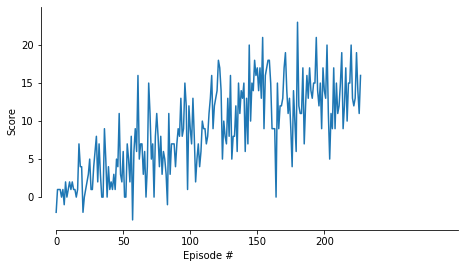

In [12]:
# Plot the scores
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots()
ax.plot(np.arange(len(scores)), scores)
ax.set_ylabel('Score')
ax.set_xlabel('Episode #')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_bounds(0, 25)
ax.spines['bottom'].set_bounds(0, 300)

In [13]:
agent.qnetwork_local.load_state_dict(torch.load('checkpoint.pth'))

In [14]:
play(random=False)

Score: -1.0


In [15]:
play(random=True)

Score: 0.0


In [16]:
env.close()

## 5. Future improvements:

To improve, we could:
1. Try more advanced DQN architectures such as Double DQN or Dueling DQN
2. Try using prioritized experience replay